In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [25]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahulmanchanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulmanchanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv("/Users/rahulmanchanda/Desktop/sentimen-analysis-nlp/data/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(418)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    return tokens


In [13]:
df['tokens'] = df['review'].apply(clean_text)


In [14]:
df["tokens"].head()

0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, theres, family, little, boy, jake,...
4    [petter, matteis, love, time, money, visually,...
Name: tokens, dtype: object

In [15]:
df["cleaned_text"] = df["tokens"].apply(lambda x: " ".join(x))


In [17]:
df["cleaned_text"].head()

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: cleaned_text, dtype: object

In [18]:
df["sentiment"]

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 49582, dtype: object

In [19]:
from sklearn.model_selection import train_test_split

X = df["cleaned_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
cv = CountVectorizer(max_features=5000)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

def train_and_evaluate(X_train, X_test, y_train, y_test, vectorizer_name):
    print(f"\n=== Results using {vectorizer_name} ===")
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(f"\n{name}")
        print("Accuracy:", accuracy_score(y_test, preds))
        print(classification_report(y_test, preds))


In [26]:
# Using Bag of Words
train_and_evaluate(X_train_cv, X_test_cv, y_train, y_test, "CountVectorizer")

# Using TF-IDF
train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")



=== Results using CountVectorizer ===

Logistic Regression
Accuracy: 0.8699203388121408
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4939
    positive       0.87      0.88      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917


Naive Bayes
Accuracy: 0.845517797721085
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      4939
    positive       0.85      0.84      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917


SVM
Accuracy: 0.8614500352929313
              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      4939
    positive       0.86      0.86      0.86      4978

    accuracy      

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],   # Regularization strength
    "penalty": ["l1", "l2"],        # Regularization type
    "solver": ["liblinear", "saga"] # solvers compatible with l1/l2
}


In [28]:
# Initialize base model
lr = LogisticRegression(max_iter=1000)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.7s
[CV] END ....................C=0.01, penalty=l1

,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [29]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.8865498550359259


In [30]:
best_lr = grid_search.best_estimator_

# Evaluate on test set
y_pred_best = best_lr.predict(X_test_tfidf)

from sklearn.metrics import classification_report, accuracy_score

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Test Accuracy: 0.8861550872239589
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4939
    positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



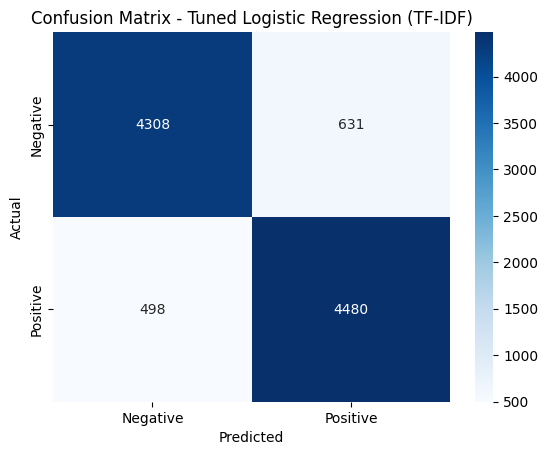

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative','Positive'],
    yticklabels=['Negative','Positive']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Logistic Regression (TF-IDF)")
plt.show()


In [32]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(best_lr, "sentiment_model.pkl")


['sentiment_model.pkl']